# 주가 예측 (ARIMA)

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller

# Time Series 생성
# 2020.09.07~2021.09.07
data_path = os.getenv('HOME') + '/aiffel/stock_prediction/005930.KS.csv'
df = pd.read_csv(data_path, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-09-07    56500.0
2020-09-08    58700.0
2020-09-09    58400.0
2020-09-10    59200.0
2020-09-11    59000.0
Name: Close, dtype: float64

In [90]:
len(ts)

249

In [91]:
# 결측치 확인
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [92]:
# 결측치 처리
# ts.interpolate(method='time')

In [93]:
# 로그변환
ts_log = np.log(ts)

In [94]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    plt.subplot(211)
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')

    plt.subplot(212)
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Standard Deviation')
    
    plt.tight_layout()
    plt.show(block=False)


def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

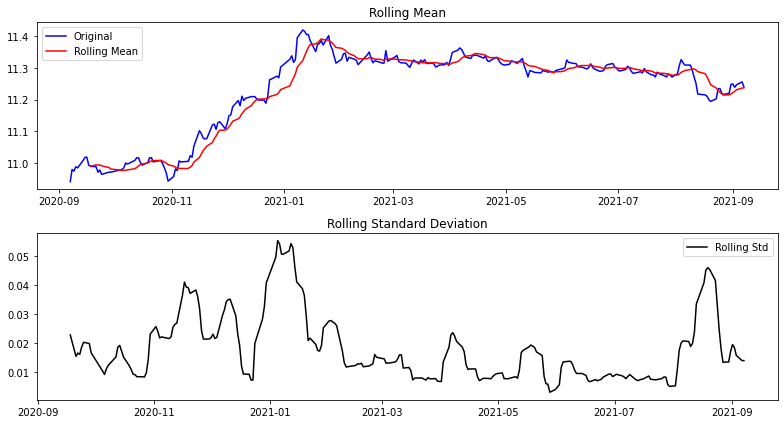

Results of Dickey-Fuller Test:
Test Statistic                  -2.317941
p-value                          0.166247
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [95]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=10)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

- 안정성을 조절해줘야 함(p값 0.16 으로 ts_log는 안정성있다고 판단하기 어려움)

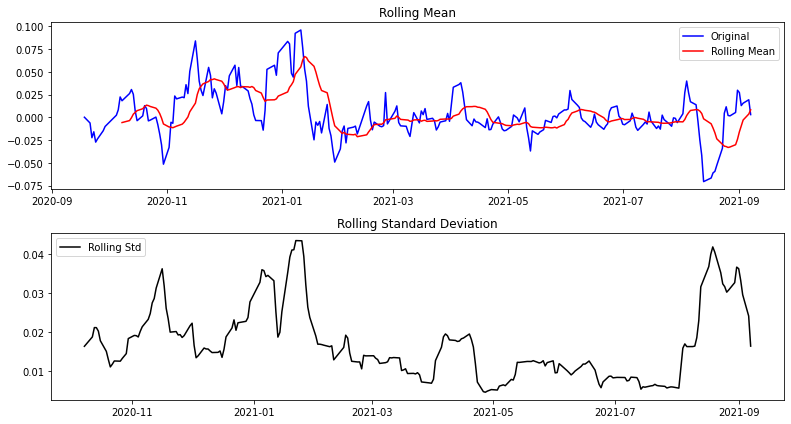

Results of Dickey-Fuller Test:
Test Statistic                  -4.554397
p-value                          0.000157
#Lags Used                       1.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


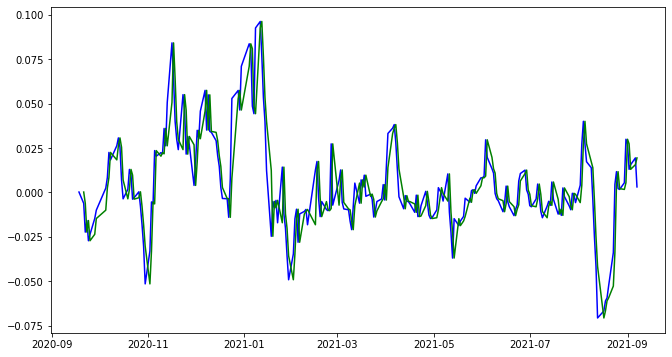

In [96]:
# moving average 제거 - trend 상쇄
moving_avg = ts_log.rolling(window=10).mean()
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.dropna(inplace=True)

plot_rolling_statistics(ts_log_moving_avg)
augmented_dickey_fuller_test(ts_log_moving_avg)

# 차분 - 계절성 파악
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

- pvalue 0.000157 로 낮아짐

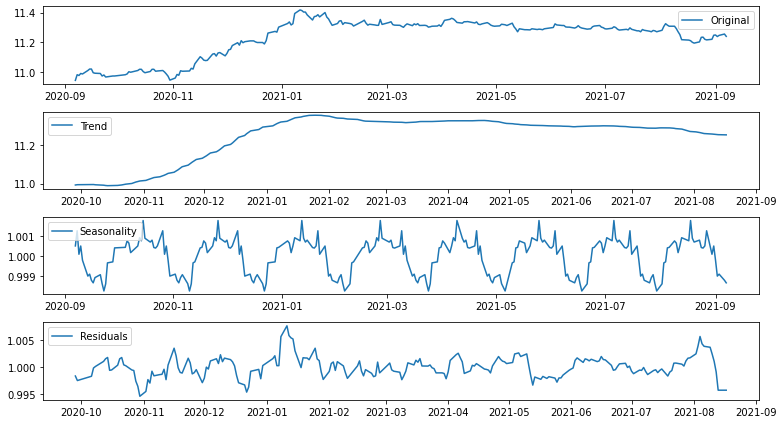

In [97]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [98]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.971511e+00
p-value                        1.931278e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.090000e+02
Critical Value (1%)           -3.462032e+00
Critical Value (5%)           -2.875471e+00
Critical Value (10%)          -2.574195e+00
dtype: float64


- pvalue 낮음. 안정적이라고 할 수 있음.

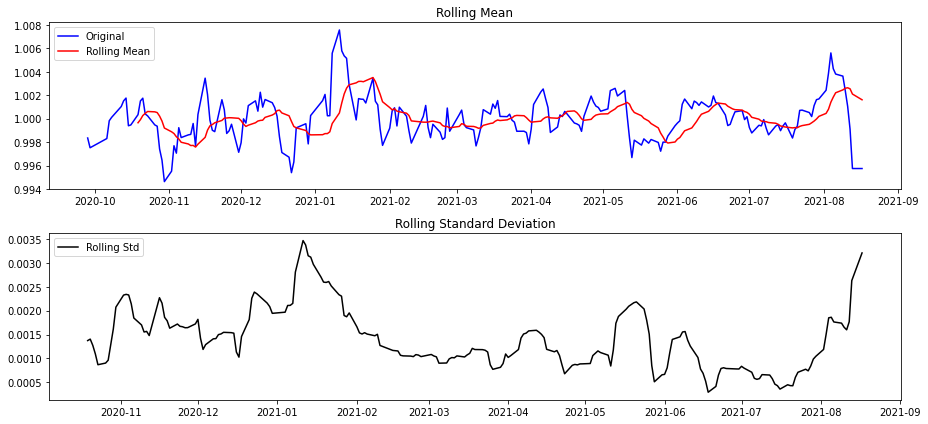

In [99]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

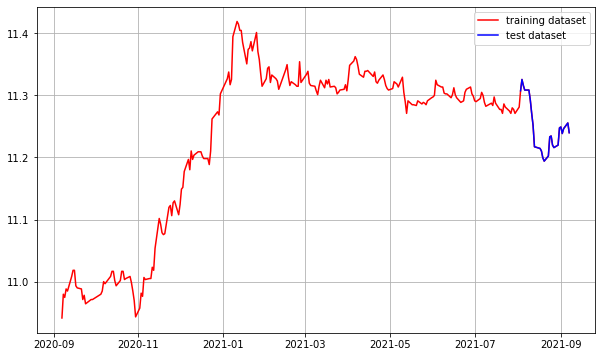

In [100]:
train_data, test_data = ts_log[:-25], ts_log[-25:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

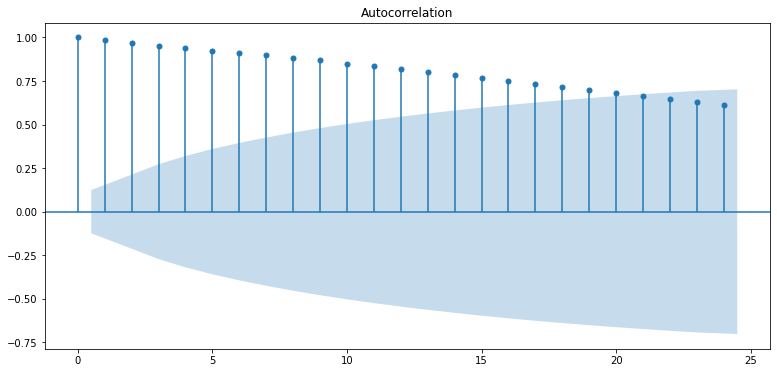

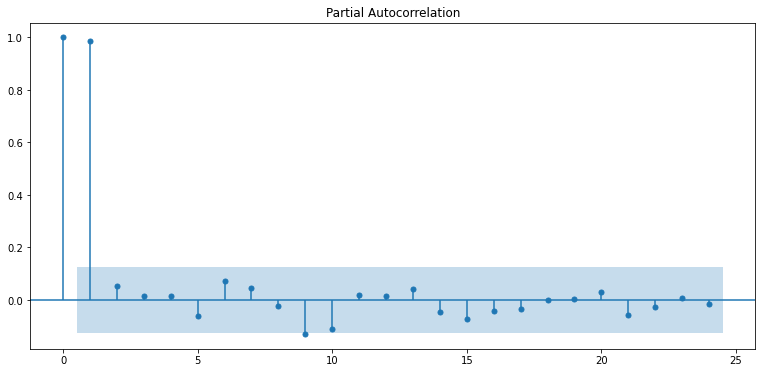

Results of Dickey-Fuller Test:
Test Statistic                -1.144065e+01
p-value                        6.190607e-21
#Lags Used                     1.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.169859e+00
p-value                        2.822955e-10
#Lags Used                     1.300000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


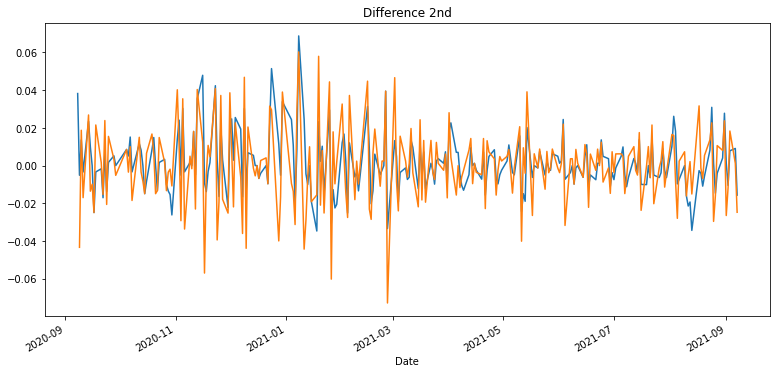

In [101]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 622.762
Method:                       css-mle   S.D. of innovations              0.015
Date:                Tue, 07 Sep 2021   AIC                          -1239.523
Time:                        15:12:13   BIC                          -1229.302
Sample:                             1   HQIC                         -1235.397
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0015      0.001      1.493      0.136      -0.000       0.004
ar.L1.D.Close     0.0293      0.068      0.432      0.666      -0.104       0.162
                                    Root

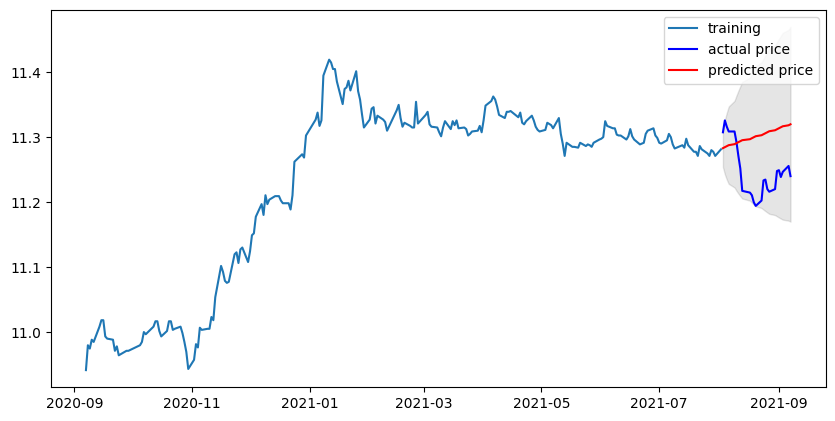

In [102]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())


# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()


In [103]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  29691989.836581055
MAE:  4965.136705014953
RMSE:  5449.035679510738
MAPE: 6.57%


## 삼성전자 주가 미래에 대한 예측 해보기

- 9.7 이후 30일 예측

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  248
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 691.326
Method:                       css-mle   S.D. of innovations              0.015
Date:                Tue, 07 Sep 2021   AIC                          -1376.652
Time:                        15:12:14   BIC                          -1366.112
Sample:                             1   HQIC                         -1372.409
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0012      0.001      1.181      0.237      -0.001       0.003
ar.L1.D.Close     0.0747      0.064      1.165      0.244      -0.051       0.200
                                    Root

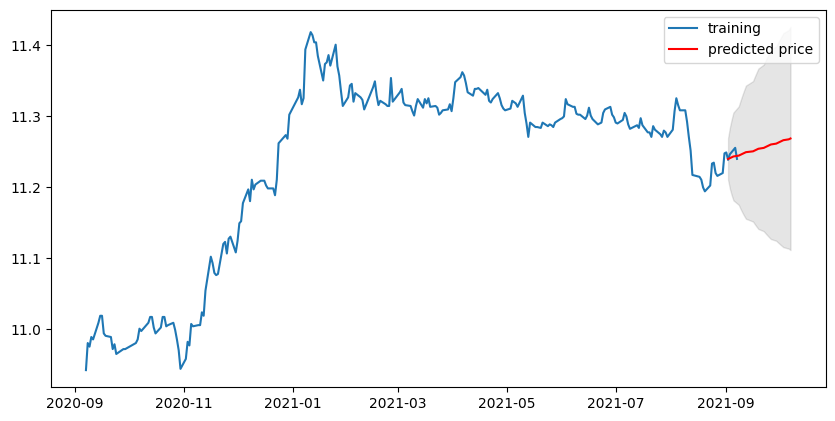

In [104]:
from datetime import timedelta

# Build Model
model = ARIMA(ts_log, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(25, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index + timedelta(days=30))   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index+ timedelta(days=30))  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index+ timedelta(days=30))  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(ts_log, label='training')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

## 다양한 주식 종가 예측해보기

In [105]:
def forecast30days(data_path):
    # 데이터 불러오기
    df = pd.read_csv(data_path, index_col='Date', parse_dates=True)
    ts = df['Close']
    ts_log = np.log(ts)
    
    
    #시계열 분해 (Time Series Decomposition)
    from statsmodels.tsa.seasonal import seasonal_decompose
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

    trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
    seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
    residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성
    
    # 시각화
    plt.rcParams["figure.figsize"] = (11,6)
    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    
    # 안정성 확인
    residual.dropna(inplace=True)
    augmented_dickey_fuller_test(residual)
    
    # 훈련, 테스트 데이터셋으로 분리
    train_data, test_data = ts_log[:-25], ts_log[-25:]
    
    # Build Model
    print('-----------------------------------------')
    print('*******ARIMA 모델로 시계열 데이터 학습********\n')
    model = ARIMA(train_data, order=(1, 1, 0))  
    fitted_m = model.fit(disp=-1)  
    print(fitted_m.summary())
    
    fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드
    
    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('>>>>>>>>>>>>>>> 훈련 결과')
    print('>>>>>>>>>>>>>>> MAPE: {:.2f}%'.format(mape*100))
    
    # Build Model
    print('\n>>>>>>>>>>>>>>>>>30일 이후 예측')
    model = ARIMA(ts_log, order=(1, 1, 0))  
    fitted_m = model.fit(disp=-1)  
    print(fitted_m.summary())

    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = fitted_m.forecast(25, alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index + timedelta(days=30))   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index+ timedelta(days=30))  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index+ timedelta(days=30))  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(ts_log, label='training')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()

In [106]:
kakao = os.getenv('HOME') + '/aiffel/stock_prediction/kakao.csv'
apple = os.getenv('HOME') + '/aiffel/stock_prediction/AAPL.csv'
lg = os.getenv('HOME') + '/aiffel/stock_prediction/lgelectronics.csv'

Results of Dickey-Fuller Test:
Test Statistic                  -5.136302
p-value                          0.000012
#Lags Used                       1.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64
-----------------------------------------
*******ARIMA 모델로 시계열 데이터 학습********

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 532.828
Method:                       css-mle   S.D. of innovations              0.022
Date:                Tue, 07 Sep 2021   AIC                          -1059.656
Time:                        15:12:14   BIC                          -1049.435
Sample:                             1   HQIC                         -1055.530
                            

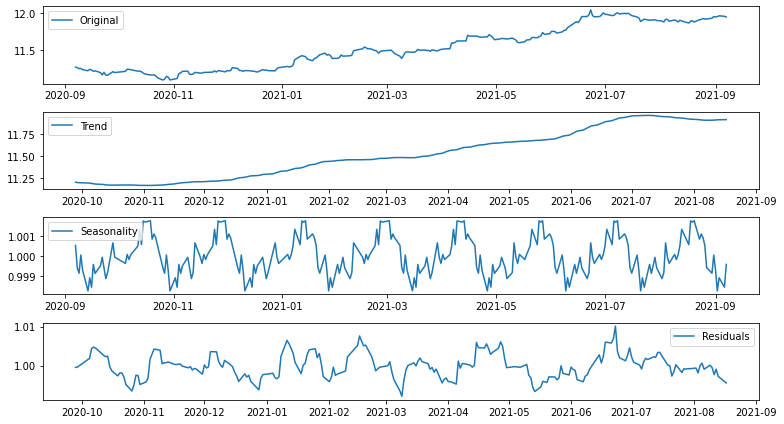

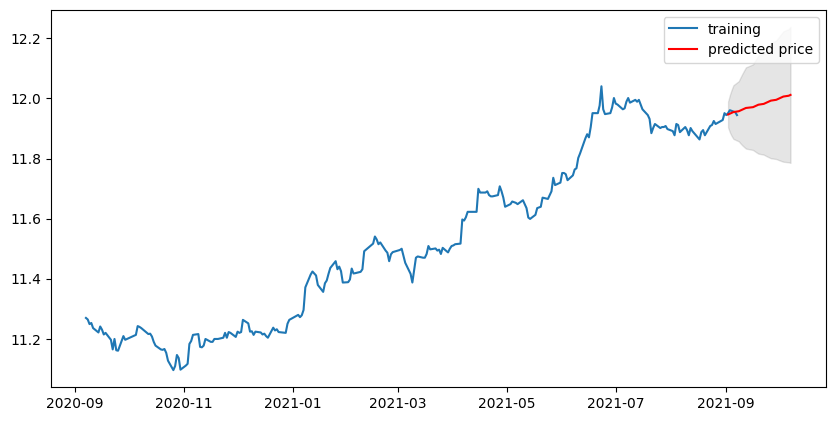

In [107]:
forecast30days(kakao)

Results of Dickey-Fuller Test:
Test Statistic                -9.521101e+00
p-value                        3.063306e-16
#Lags Used                     2.100000e+01
Number of Observations Used    1.206000e+03
Critical Value (1%)           -3.435784e+00
Critical Value (5%)           -2.863940e+00
Critical Value (10%)          -2.568048e+00
dtype: float64
-----------------------------------------
*******ARIMA 모델로 시계열 데이터 학습********

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1232
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3131.908
Method:                       css-mle   S.D. of innovations              0.019
Date:                Tue, 07 Sep 2021   AIC                          -6257.815
Time:                        15:12:15   BIC                          -6242.466
Sample:                             1   HQIC                         -6252.041
              

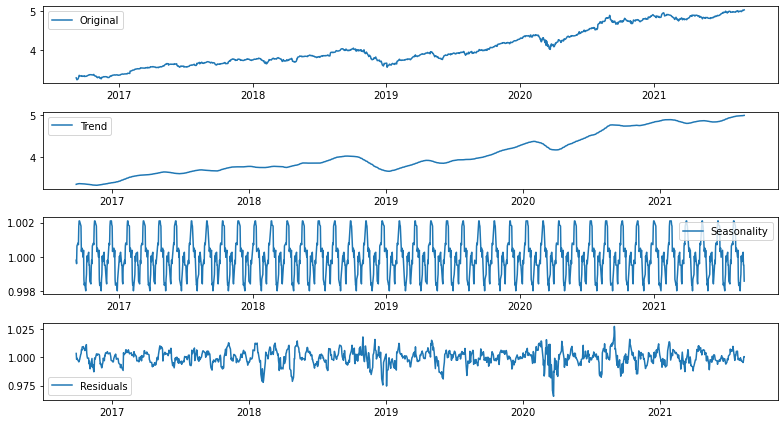

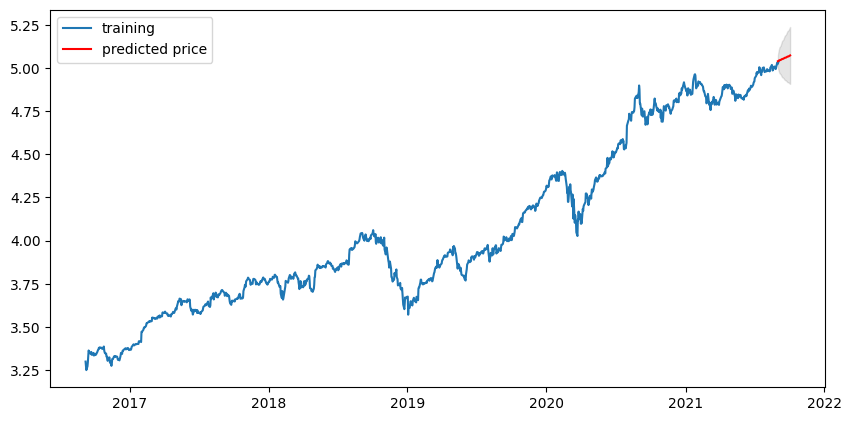

In [108]:
forecast30days(apple)

Results of Dickey-Fuller Test:
Test Statistic                  -5.492708
p-value                          0.000002
#Lags Used                       0.000000
Number of Observations Used    218.000000
Critical Value (1%)             -3.460708
Critical Value (5%)             -2.874891
Critical Value (10%)            -2.573886
dtype: float64
-----------------------------------------
*******ARIMA 모델로 시계열 데이터 학습********

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 445.121
Method:                       css-mle   S.D. of innovations              0.033
Date:                Tue, 07 Sep 2021   AIC                           -884.241
Time:                        15:12:16   BIC                           -874.020
Sample:                             1   HQIC                          -880.115
                            

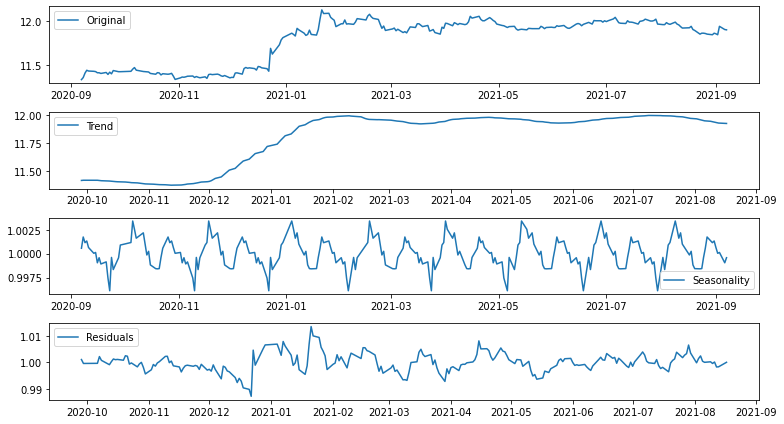

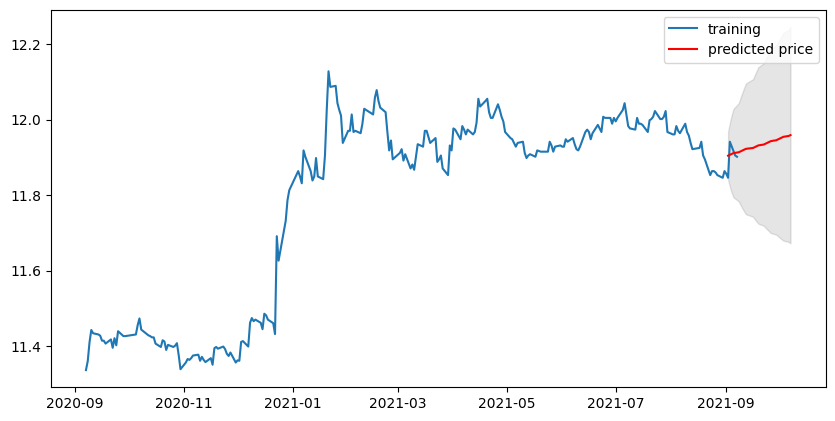

In [109]:
forecast30days(lg)

- 모델은 삼성전자, 카카오, 애플, lg전자 주가가 상승할 것으로 예측하고 있습니다.